In [41]:
import pandas
import matplotlib.pyplot as plt

In [287]:
# Inclusive range for dicing
YEARS = (2015, 2023)
MONTHS = (10, 12)

# Download S&P 500 stock prices history as a CSV and parse the date

In [322]:
# https://www.nasdaq.com/market-activity/index/spx/historical?page=102&rows_per_page=25&timeline=y10
spx = pandas.read_csv('60-SPX.csv')
spx = spx.reindex(index=spx.index[::-1])
spx = spx.reset_index(drop=True)
del spx['Open']
del spx['Close/Last']
spx['Year'] = spx['Date'].str.split('/', expand=True)[2].astype(int)
spx['Month'] = spx['Date'].str.split('/', expand=True)[0].astype(int)
spx['Day'] = spx['Date'].str.split('/', expand=True)[1].astype(int)
spx

,Date,High,Low,Year,Month,Day
0,08/26/2014,2005.04,1998.59,2014,8,26
1,08/27/2014,2002.14,1996.20,2014,8,27
2,08/28/2014,1998.55,1990.52,2014,8,28
3,08/29/2014,2003.38,1994.65,2014,8,29
4,09/01/2014,0.00,0.00,2014,9,1
...,...,...,...,...,...,...
2523,08/19/2024,5608.30,5550.74,2024,8,19
2524,08/20/2024,5620.51,5585.50,2024,8,20
2525,08/21/2024,5632.68,5591.57,2024,8,21
2526,08/22/2024,5643.22,5560.95,2024,8,22


# Download the target stock (M) prices history and parse the date

In [323]:
# https://finance.yahoo.com/quote/M/history/
prices = pandas.read_csv('60-M.csv')

del prices['Open']
del prices['Close']
del prices['Adj Close']
del prices['Volume']
prices['Year'] = prices['Date'].str.split('-', expand=True)[0].astype(int)
prices['Month'] = prices['Date'].str.split('-', expand=True)[1].astype(int)
prices['Day'] = prices['Date'].str.split('-', expand=True)[2].astype(int)

# Merge the two datasets using date
Discard any rows with incomplete data

In [316]:
df = pandas.merge(spx, prices, on=['Year', 'Month', 'Day'], how='inner', suffixes=('Spx', 'Stock'))
df = df[(YEARS[0] <= df.Year) & (df.Year <= YEARS[1]) & (MONTHS[0] <= df.Month) & (df.Month <= MONTHS[1])]
df['didx'] = [
    d
    for year in range(YEARS[0], YEARS[1] + 1)
    for d in range((df.Year == year).sum())
]
df.describe()

,HighSpx,LowSpx,Year,Month,Day,HighStock,LowStock,didx
count,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000
mean,3249.744991,3215.057180,2018.998249,10.984238,15.562172,25.290193,24.382172,31.224168
std,899.323476,888.901796,2.582328,0.821699,8.823070,11.689632,11.410891,18.331992
min,1927.210000,1893.700000,2015.000000,10.000000,1.000000,5.990000,5.570000,0.000000
25%,2556.490000,2543.895000,2017.000000,10.000000,8.000000,15.915000,15.395000,15.000000
50%,3098.200000,3083.260000,2019.000000,11.000000,15.000000,23.059999,22.040001,31.000000
75%,3981.490000,3935.905000,2021.000000,12.000000,23.000000,35.070002,33.399999,47.000000
max,4808.930000,4780.980000,2023.000000,12.000000,31.000000,52.480000,51.209999,63.000000


# Square up the data

We want to plot several years on the same chart, so let's trim the excess. For all the covered years find the smallest last day index.

In [324]:
years = list(range(min(df.Year), max(df.Year) + 1))
max_didx = min(max(df[df.Year==year].didx) for year in years)
min_didx = max(min(df[df.Year==year].didx) for year in years)
didxs = list(range(min_didx, max_didx + 1))

# Plot

1. The stock price deviations for the selected months range over the selected years.
2. The S&P index price for the same dates.
3. Stock price corrected to S&P index.

Note that we plot percentage changes of the stock from the first day of the season. On day one all prices are at 0%, and then for each year they deviate.

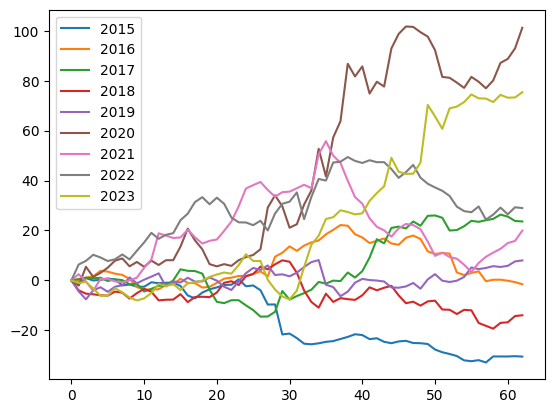

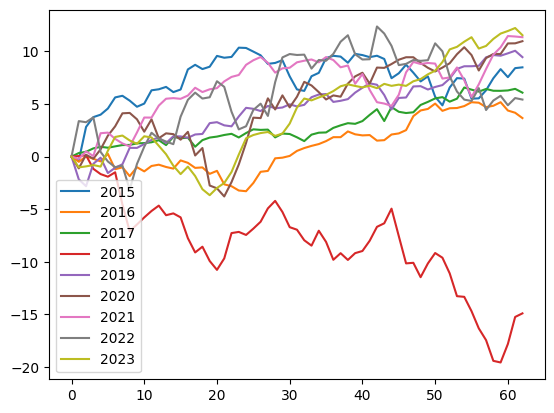

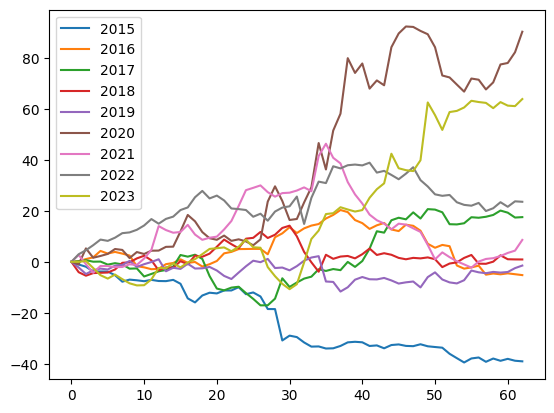

In [325]:
def convert_to_season(df, y, years, didxs):
    base = dict(zip(df.Year[df.didx==0], y[df.didx==0]))
    return pandas.DataFrame(
        [
            [
                (y[(df.Year==year) & (df.didx==didx)].iloc[0] - base[year]) * 100 / base[year]
                for year in years
            ]
            for didx in didxs
        ],
        columns=map(str, years)
    )

stock_seasons = convert_to_season(df, df.LowStock, years, didxs)
spx_seasons = convert_to_season(df, df.LowSpx, years, didxs)
stock_seasons.plot()
spx_seasons.plot()
(stock_seasons - spx_seasons).plot();